#Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/Users/adrian/Repos/seminar_critical-social-media-analysis/adrian_gruszczynski_assignment4/venv/bin/python


# Install dependencies:

In [ ]:
!pip3 install tensorflow==2
!pip3 install anaconda pandas
!pip3 install tensorflow-hub
!pip3 install html2text
!pip3 install tqdm
!pip3 install scikit-learn
!pip3 install matplotlib
!pip3 install seaborn

# Imports

In [2]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [20]:
data_path = './data/videoinfo_DkZ7BJQupVA_2020_11_21-11_04_37_comments.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [21]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Successfully created the directory ./output/ 


# Load Data
Load you data as a pandas dataframe

In [22]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [23]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [24]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

/Users/adrian/Repos/seminar_critical-social-media-analysis/adrian_gruszczynski_assignment4/venv/lib/python3.7/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 6118/6118 [00:00<00:00, 6636.08it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [25]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-11-19 15:14:54,Joshua Benito,"<a href=""https://www.youtube.com/watch?v=DkZ7BJQupVA&amp;t=3m46s"">3:46</a> Yeap! Just like you white folks do when you see a POC in your neighborhood. 😒",0,3:46 Yeap! Just like you white folks do when you see a POC in your\nneighborhood. 😒\n\n
1,2020-11-19 10:13:49,Shauna McConnoran,in ireland most of us dont have dishwashers or thumbledryers.<br />theyre not needed,0,in ireland most of us dont have dishwashers or thumbledryers. \ntheyre not needed\n\n
2,2020-11-19 10:16:31,Shauna McConnoran,my family doesnt even have a car,1,my family doesnt even have a car\n\n
3,2020-11-18 13:33:22,Iva Zadro,Such a great video!,0,Such a great video!\n\n
4,2020-11-18 08:31:05,Justin Y.,&quot;Yeh if its black we would have deal with it long ago&quot; I see What you did there.,0,"""Yeh if its black we would have deal with it long ago"" I see What you did\nthere.\n\n"


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [26]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [27]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 The embeddings vector is of fixed length 512


TensorShape([6118, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 0.9999999   0.13952315  0.08261704 ...  0.00992764 -0.05061378
   0.00992765]
 [ 0.13952315  1.0000001   0.30842233 ...  0.05084531  0.1589114
   0.05084532]
 [ 0.08261704  0.30842233  0.99999994 ...  0.03506356  0.05926912
   0.0350636 ]
 ...
 [ 0.00992764  0.05084531  0.03506356 ...  1.          0.27492604
   1.        ]
 [-0.05061378  0.1589114   0.05926912 ...  0.27492604  0.99999994
   0.27492598]
 [ 0.00992765  0.05084532  0.0350636  ...  1.          0.27492598
   1.0000001 ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

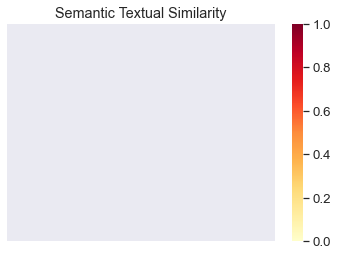

In [35]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 10000

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [30]:
comment_index = 324
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

dont worry covid 19 is fixing it




Print similar comments.

In [31]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: dont worry covid 19 is fixing it


Top similar comment 2:  covid solved climate change


Top similar comment 3: Its gonna be too late before you can fix it.


Top similar comment 4: Quick fix, everyone go vegan


Top similar comment 5: We should talk about fixing it.


Top similar comment 6: Well if we can't fix it we shall evolve!


Top similar comment 7: Scientists are actually trying to fix it it's cool look it up it's
interesting.


Top similar comment 8: @ Dont blame others


Top similar comment 9: there is a quick fix, it's called government


Top similar comment 10: honestly im worried for that dude's future


Top similar comment 11: people like you are not helping to solve the problem


Top similar comment 12: God damnit XD


Top similar comment 13: ty I see a big issue now!


Top similar comment 14: I got an idea! Let's blame the Republicans!


Top similar comment 15: Yay the world is gonna die.


Top similar comment 16: "Tal" is NOT doing a damn thing. 